In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.datasets import make_classification, make_blobs, load_boston, fetch_california_housing

In [3]:
# download dataset
cal=fetch_california_housing()

In [4]:
# checking structure of data set
print(cal.keys())

dict_keys(['data', 'target', 'feature_names', 'DESCR'])


In [5]:
cal.DESCR

'California housing dataset.\n\nThe original database is available from StatLib\n\n    http://lib.stat.cmu.edu/datasets/\n\nThe data contains 20,640 observations on 9 variables.\n\nThis dataset contains the average house value as target variable\nand the following input variables (features): average income,\nhousing average age, average rooms, average bedrooms, population,\naverage occupation, latitude, and longitude in that order.\n\nReferences\n----------\n\nPace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions,\nStatistics and Probability Letters, 33 (1997) 291-297.\n\n'

In [6]:
cal.data

array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
          37.88      , -122.23      ],
       [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
          37.86      , -122.22      ],
       [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
          37.85      , -122.24      ],
       ...,
       [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
          39.43      , -121.22      ],
       [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
          39.43      , -121.32      ],
       [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
          39.37      , -121.24      ]])

In [7]:
#Let's use GBRT to build a model that can predict house prices.
# cal.target is the target variable
# cal.data is the features

#Split to train test set
from sklearn.model_selection import train_test_split
#Default split is 75 25
X_train, X_test, Y_train, Y_test = train_test_split(cal.data, cal.target)

In [8]:
print(X_train.shape, X_test.shape)

(15480, 8) (5160, 8)


In [9]:
from sklearn.ensemble import GradientBoostingRegressor

In [10]:
# fit a simple model first
gbrt = GradientBoostingRegressor(n_estimators=100)
gbrt.fit(X_train, Y_train)
y_pred = gbrt.predict(X_test)

In [11]:
#benefit of trees - can understand importance of each feature
gbrt.feature_importances_

array([0.17618047, 0.05412529, 0.0606919 , 0.04165923, 0.02937168,
       0.09929731, 0.24943756, 0.28923656])

In [12]:
#printg R squared value for train/test. 
# explains how much of the variance in the data our model is able to decipher.
print('R squared for training set: ', gbrt.score(X_train,Y_train))
print('R squared for testing set: ', gbrt.score(X_test,Y_test))

R squared for training set:  0.8088883945883185
R squared for testing set:  0.7795025270731238


In [13]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

In [14]:
# hyperparameters are extremely critical to the model. 
#Now, if we tune parameters against the Test dataset, we will end up biasing towards the test set and will once again #not generalize very well. We will also have no good way to find out since we have essentially trained on all our data. 
#Luckily scikit-learn has builit-in packages that can help with this. 
# We'll use a crossvalidation generator that can train the model by tuning the parameters based on a cross-validation subset (cv) that is picked from within the training set.
# A different cv subset will be picked for each iteration, we control the number of iterations. 
# Then we will use these cv/train splits and run a gridsearch function that will evaluate the model with each split and tune parameters 
#to give us the best parameter that gives the optimal result. 
    
#Defining this as a function so we can call it anytime we want 


def GradientBooster(param_grid, n_jobs):
    estimator = GradientBoostingRegressor()
    #Choose cross-validation generator - let's choose ShuffleSplit which randomly shuffles and selects Train and CV sets 
    #for each iteration. There are other methods like the KFold split.
    
    #n_splits controls number of re-shuffling/iterations
    cv = ShuffleSplit(n_splits=10, test_size=0.2)
    
    #Apply the cross-validation iterator on the Training set using GridSearchCV. 
    # This will run the classifier on the different train/cv splits using parameters specified and return the model that has the best results.
    
    classifier = GridSearchCV(estimator = estimator, cv=cv, param_grid = param_grid)
    
    #fit the training dataset to this classifier
    classifier.fit(X_train,Y_train)
    
    #printing results
    print('Best estimator learned through GridSearch')
    print(classifier.best_estimator_)
    
    return cv, classifier.best_estimator_

In [15]:
#Below is a plot_learning_curve module that's provided by scikit-learn. It allows us to quickly and easily visualize how 
#well the model is performing based on number of samples we're training on. It helps to understand situations such as 
#high variance or bias.

import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

In [16]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """ Generate a simple plot of the test and traning learning curve. 
    Parameters ---------- 
    estimator : object type that implements the "fit" and "predict" methods.
    An object of that type which is cloned for each validation. 
    title : string Title for the chart. 
    X : array-like, shape (n_samples, n_features) 
    Training vector, where n_samples is the number of samples and n_features is the number of features. 
    y : array-like, shape (n_samples) or (n_samples, n_features), 
    optional Target relative to X for classification or regression; None for unsupervised learning. 
    ylim : tuple, shape (ymin, ymax), optional 
    Defines minimum and maximum yvalues plotted. 
    cv : integer, cross-validation generator, optional 
    If an integer is passed, it is the number of folds (defaults to 3). 
    Specific cross-validation objects can be passed, see sklearn.cross_validation module for the list of possible objects 
    n_jobs : integer, optional Number of jobs to run in parallel (default 1). """ 
    
    
    plt.figure() #Create figure (?)
    plt.title(title) #Give title to plot
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    #call learning_curve function - see documetation for further details
    train_sizes, train_scores, test_scores = learning_curve(estimator, X,y, cv=cv, n_jobs = n_jobs, train_sizes = train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label="Cross-validation score")
    
    plt.legend(loc='best')
    
    return plt

In [17]:
param_grid = {'n_estimators':[100], 
              'learning_rate' :[0.1,0.05], 
              'max_depth':[8,6],
              'min_samples_leaf':[3,5],
              'max_features':[1.0,0.3]} 

n_jobs=1

cv,best_est = GradientBooster(param_grid, n_jobs)

Best estimator learned through GridSearch
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=8, max_features=1.0,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=5,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)


In [18]:
cv

ShuffleSplit(n_splits=10, random_state=None, test_size=0.2, train_size=None)

In [19]:
#get back the best estimator's parameters
print('Best Estimator Parameters')
print('------------')
print ("n_estimators: " ,best_est.n_estimators)
print ("max_depth: ", best_est.max_depth)
print ("Learning Rate: ", best_est.learning_rate)
print ("min_samples_leaf: ", best_est.min_samples_leaf)
print ("max_features: " ,best_est.max_features)

print("Training R-squared: ", best_est.score(X_train,Y_train))

Best Estimator Parameters
------------
n_estimators:  100
max_depth:  8
Learning Rate:  0.1
min_samples_leaf:  5
max_features:  1.0
Training R-squared:  0.9459445132884438


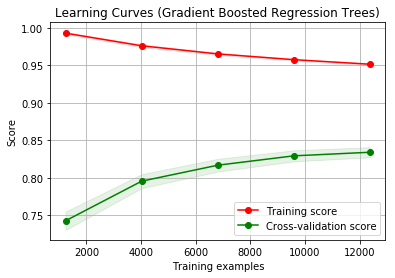

In [20]:
#OK we'll now call the plot_learning_curve module by feeding it the estimator (best estimator returned from GS) #and train/cv sets. 
#The module simply runs the estimator multiple times on subsets of the data provided and plots the train and cv scores.
#Note that we're feeding the best parameters we've learned from GridSearchCV to the estimator now. 
#We may need to adjust the hyperparameters further if there is overfitting (or underfitting, though unlikely)


title = "Learning Curves (Gradient Boosted Regression Trees)" 
estimator = GradientBoostingRegressor(n_estimators=best_est.n_estimators, 
                                      max_depth=best_est.max_depth, 
                                      learning_rate=best_est.learning_rate, 
                                      min_samples_leaf=best_est.min_samples_leaf, 
                                      max_features=best_est.max_features)
plot_learning_curve(estimator, title, X_train, Y_train, cv=cv, n_jobs=n_jobs) #use cv and n_jobs from above
plt.show()

In [21]:
# observation of learning curve 
# MIGHT be able to do a bit better with more estimators. 
# Although we may MAY NEED TO REDUCE LEARNING RATE even further to address any overfitting. 
# indicative of overfitting : look at the WIDE GAP b/w train and cv curves.
# This possibly could be addressed by further reducing learning rate. 
# But note if CV scores are pretty much the same, we might not see a major improvement unless we can procure more samples.

In [22]:
#Test R-squared using best estimator
print("Test set R-squared: ", best_est.score(X_test,Y_test))

Test set R-squared:  0.8300973778961439


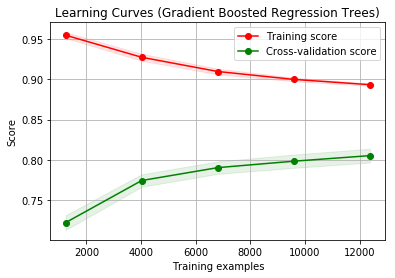

In [23]:
# Test if reduce learning rate
title = "Learning Curves (Gradient Boosted Regression Trees)" 
estimator = GradientBoostingRegressor(n_estimators=best_est.n_estimators, 
                                      max_depth=best_est.max_depth, 
                                      learning_rate=0.03, 
                                      min_samples_leaf=best_est.min_samples_leaf, 
                                      max_features=best_est.max_features)
plot_learning_curve(estimator, title, X_train, Y_train, cv=cv, n_jobs=n_jobs) #use cv and n_jobs from above
plt.show()

In [24]:
#Test R-squared using modified estimator
#Re-fitting to the train set 
estimator.fit(X_train, Y_train) 
print("Training R-squared: ", estimator.score(X_train,Y_train))
print("Test set R-squared: ", estimator.score(X_test,Y_test))

Training R-squared:  0.8859555372536595
Test set R-squared:  0.7997875286700344


In [25]:
#advantages of growing trees. capture feature importances.
#Calling fit on the estimator so we can look at feature_importances. 
estimator.fit(X_train, Y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.03, loss='ls', max_depth=8, max_features=1.0,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=5,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [26]:
#Calculate the feature ranking - top 10 
importances = estimator.feature_importances_
index = np.argsort(importances) #return indices that sorts
index

array([3, 4, 2, 1, 5, 6, 7, 0], dtype=int64)

In [27]:
estimator.feature_importances_

array([0.39256213, 0.05070777, 0.04935761, 0.03151366, 0.03348613,
       0.11988716, 0.15903293, 0.16345262])

In [28]:
indices2= index[::-1] #reverse the array of indices

In [29]:
indices2

array([0, 7, 6, 5, 1, 2, 4, 3], dtype=int64)

In [30]:
cal.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [31]:
print("Top 5 Important Features\n")
for i in range(5):
    print('{} ({})'.format(cal.feature_names[indices2[i]], importances[indices2[i]]))

Top 5 Important Features

MedInc (0.39256213125795447)
Longitude (0.16345261562912863)
Latitude (0.1590329257358781)
AveOccup (0.11988716121833834)
HouseAge (0.050707765277785866)


TypeError: only integer scalar arrays can be converted to a scalar index

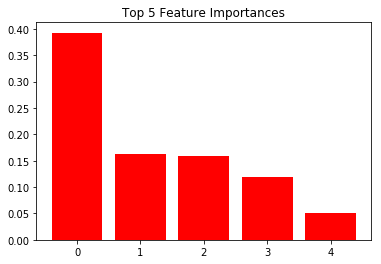

In [32]:
#plot the feature importances - top5
indices2=indices2[:5] #choose only first 5
plt.figure()
plt.title("Top 5 Feature Importances")
plt.bar(range(5), importances[indices2],color='r',align='center')
plt.xticks(range(5),np.asarray(cal.feature_names[indices2]),fontsize=14, rotation=45)
plt.xlim([-1,5])
plt.show()